In [ ]:
# default_exp behavior_control_congruency

# Behavior-control-congruency
ToDo: Where it makes sense, run mixed models.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)
from IPython.core.display import HTML
from trr265.gbe.data_provider import GBEProvider
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

In [ ]:
dp = GBEProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
two_day = dp.get_two_day_data()

In [ ]:
ba = dp.get_ba_data().query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud[aud.participant.isna()==False]


## Intention to control
We base the intention-behavior congruency on the following question, which participants answered every 8 days: 

"Planen Sie, Ihren Alkoholkonsum die nächsten 8 Tagen zu begrenzen?"
("Do you plan to limit your alcohol consumption in the next 8 days?"
  1) NEIN, ich habe keine speziellen Vorsätze (No, I don't have special intentions)
  2) JA, ich möchte nicht mehr als üblich trinken (Yes, I do not want to drink more than I usually do)
  3) JA, ich möchte weniger als üblich trinken (Yes, I want to drink less than I usually do)

> Perhaps in follow-up study we should change this question, to make answers more precise (e.g. "To which extend do you want to change your drinking?" (e.g. use a slider to make glass bigger or smaller).

### Descriptives

<AxesSubplot:xlabel='limit', ylabel='count'>

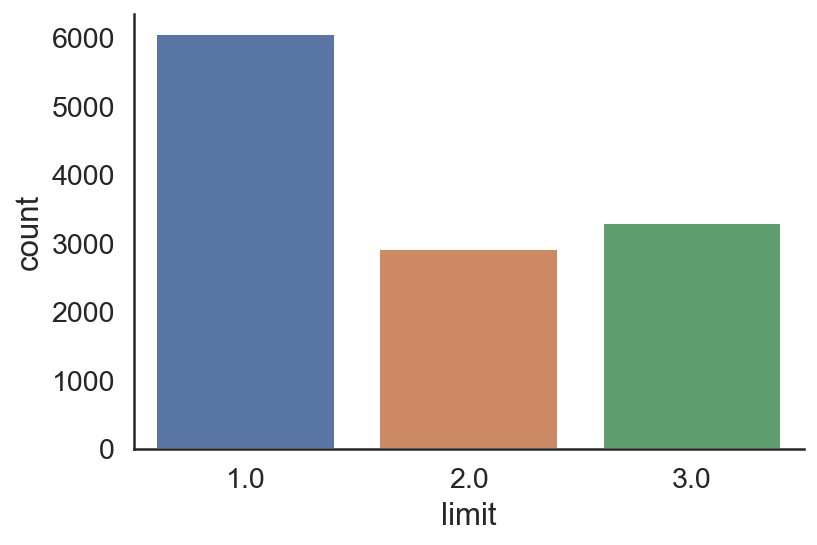

In [ ]:
sns.countplot(df.limit) # This df is created after limit agg

In [ ]:
def prevalence(df, text):
    display(HTML("%d participants at least once %s (%d events in total)."%(len(df.participant.unique()), text, len(df))))

In [ ]:
prevalence(df[df.limit>1], 'intended to limit their consumption')

## Change in drinking
To calculate change in drinking, we compare participants drinking behavior in the 7 days before the intention was reported to their drinking behavior in the 7 days after they reported their intention.

### Compliance

<AxesSubplot:>

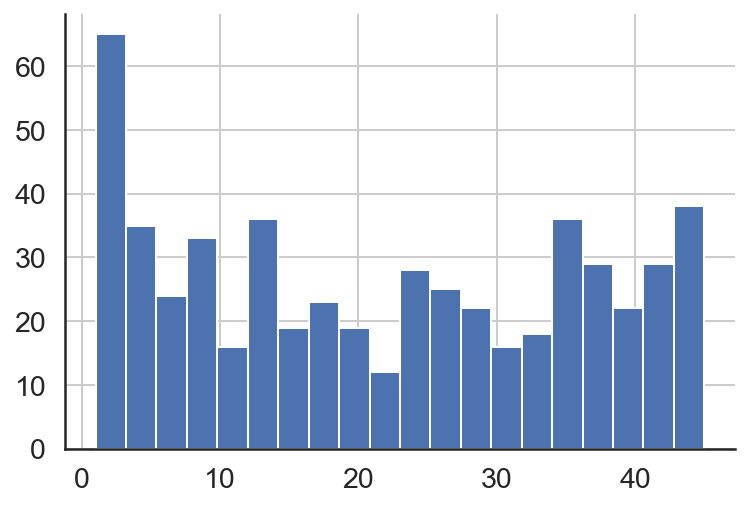

In [ ]:
df.groupby('participant').size().hist(bins = 20)

### Example calculation
The raw data contains one row per participant-date. Here, we aggregate, so that we get one row per reported intention, which includes the intention, the average (mean) consumption before the intention and the average (mean) consumption after the intention.
> Note that in our main longitudinal analyses we aggregate with the median. Perhaps we should try this here as well.

In [ ]:
# Note that this does not generalize to overlapping periods
import numpy as np
from datetime import timedelta


def window_agg(df, window, inclusive):
    if inclusive:
        window -= 1
    df['limit_date'] = df['date']
    df.loc[df.Limit.isnull(),'limit_date'] = np.nan
    if window < 0:
        df['limit_date'] = df.limit_date.bfill(limit=-window)
        df['limit_shifted'] = df.Limit.bfill(limit=-window)
    elif window > 0:
        df['limit_date'] = df.limit_date.ffill(limit=window)
        df['limit_shifted'] = df.Limit.ffill(limit=window)
    if not inclusive:
        df.loc[df.Limit.isnull()==False,'limit_date'] = np.nan
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        #display(df)

    return df.groupby('limit_date').agg({'limit_shifted':np.mean,'g_alc':np.mean})

def limit_agg(df):
    limit_df = window_agg(df, -7, False)
    limit_df['after'] = window_agg(df, 7, True)['g_alc']
    limit_df.columns = ['limit','before','after']
    limit_df['difference'] = limit_df.after-limit_df.before
    return limit_df

    
df = two_day[['participant','date','Limit','g_alc']].query('participant=="b001"')

display(limit_agg(df).iloc[:10])

,limit,before,after,difference
limit_date,,,,
2020-03-25,2.0,9.314286,13.714286,4.400000
2020-04-02,2.0,16.228571,17.600000,1.371429
2020-04-20,2.0,22.171429,7.920000,-14.251429
2020-04-28,2.0,6.600000,4.600000,-2.000000
2020-05-30,2.0,11.666667,24.800000,13.133333
2020-06-23,2.0,25.800000,19.800000,-6.000000
2020-07-09,2.0,16.000000,24.285714,8.285714
2020-07-17,2.0,32.685714,NaN,NaN
2020-07-29,2.0,18.300000,1.600000,-16.700000


### Aggregation and missing data

In [ ]:
len(two_day.participant.unique())

595

In [ ]:
assert len(two_day.participant.unique()) == 595, "number of participants changed"

In [ ]:
df = two_day.groupby('participant').apply(limit_agg).reset_index()

In [ ]:
missing = df.difference.isna().sum()
display(HTML('''For %d reported intentions, no difference in alcohol consumption could be calculated.'''%missing))
assert missing == 436, "Number of missing differences in consumption changed"

In [ ]:
df = df[df.difference.isna()==False]

In [ ]:
display(HTML('''After removing lines with missing data, we still have data from %d participants.'''%len(df.participant.unique())))

### Descriptives

<AxesSubplot:>

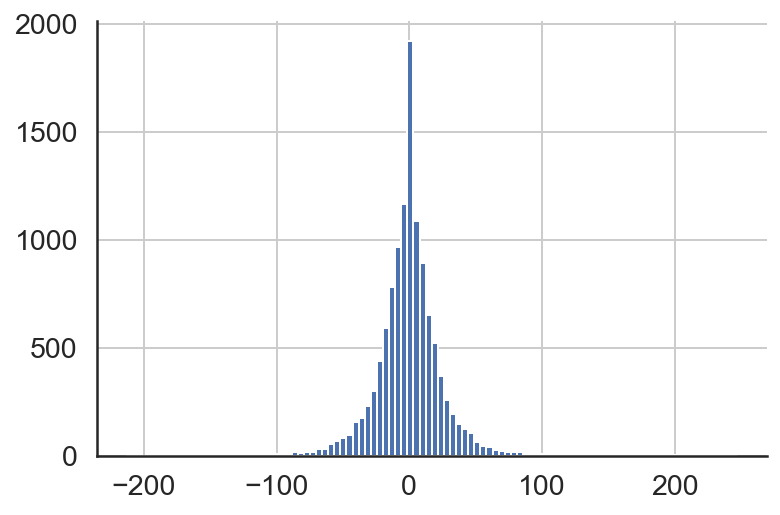

In [ ]:
df.difference.hist(bins=100)

In [ ]:
df.difference.describe()

count    11824.000000
mean        -0.535927
std         24.170991
min       -212.600000
25%        -11.600000
50%          0.000000
75%         10.742857
max        246.400000
Name: difference, dtype: float64

### Relationship to intention to control (participant level)
At participant level, intention and change in drinking are not correlated (i.e., participants who generally want to reduce drinking more do not generally increase or decrease their drinking).

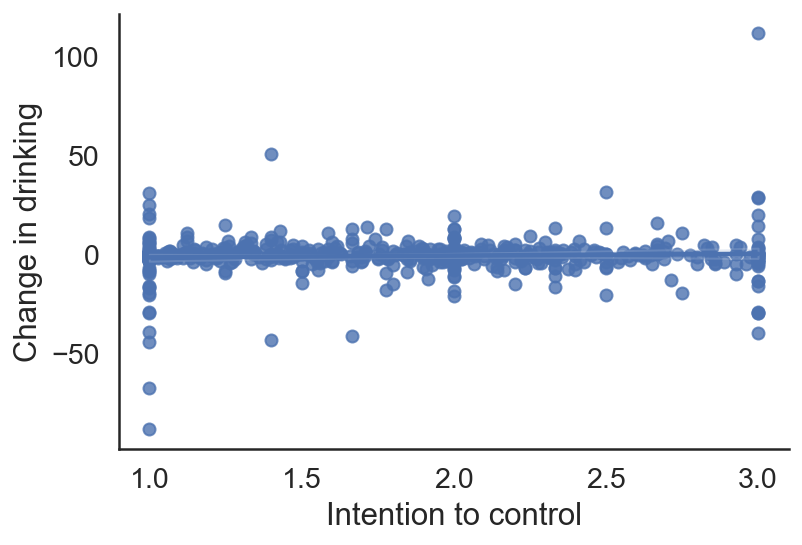

In [ ]:
pp_data = df.groupby('participant').mean()
ax = sns.regplot(x = 'limit', y = 'difference', data = pp_data)
ax.set_xlabel('Intention to control')
ax.set_ylabel('Change in drinking')
plt.show()
r, p = pearsonr(pp_data.limit, pp_data.difference)
display(HTML('''<i>r</i> = %.2f, <i>p</i> = %.2f'''%(r,p)))
assert np.isclose(r, .054, rtol=1e-02), "The correlation between intention to control and change in drinking changed."

## Intention-behavior congruency
To calculate congruency we correlate the limit variable with change in drinking for each participant. Finally, we calculate the additive inverse to make the correlation more interpretable.

In [ ]:
# ToDo: Should say how many are removed because of too little data and because of no variance, plot significance
def get_correlations(df, predictor = 'limit', min_data = 2):
    correlations = []
    for pp in df.participant.unique():
        pp_df = df.query("participant==@pp")
        if len(pp_df)>=min_data:
            r, p = pearsonr(pp_df[predictor], pp_df['difference'])
            correlations.append({'participant':pp,'r':r,'p':p})
    correlations = pd.DataFrame(correlations) 
    correlations = correlations[correlations.r.isna()==False]
    correlations = correlations.set_index('participant')
    correlations['r'] = correlations.r * -1
    return correlations

ToDo: Also try spearman

To categorize we could just go for a median split. Participants at the median only have 2% explained variance of drinking change based on limit. Or move a bit away from the median to have a bigger difference between groups.

In [ ]:
correlations = get_correlations(df, min_data = 2)

ToDo: Try mixed models and see if results differ (mixed models also give sig. for indiv. slopes). Here we could also add additional variables (e.g. age, gender, or within-pp participant variables).

### Descriptives

In [ ]:
display(HTML('''Correlations could be calculated for %d participants.'''%len(correlations)))
assert len(correlations) == 410, "Number of calculated correlations changed"

                r           p
count  410.000000  410.000000
mean     0.139172    0.438562
std      0.319456    0.319582
min     -1.000000    0.000283
25%     -0.018143    0.136127
50%      0.150108    0.414771
75%      0.328036    0.698850
max      1.000000    1.000000


<AxesSubplot:>

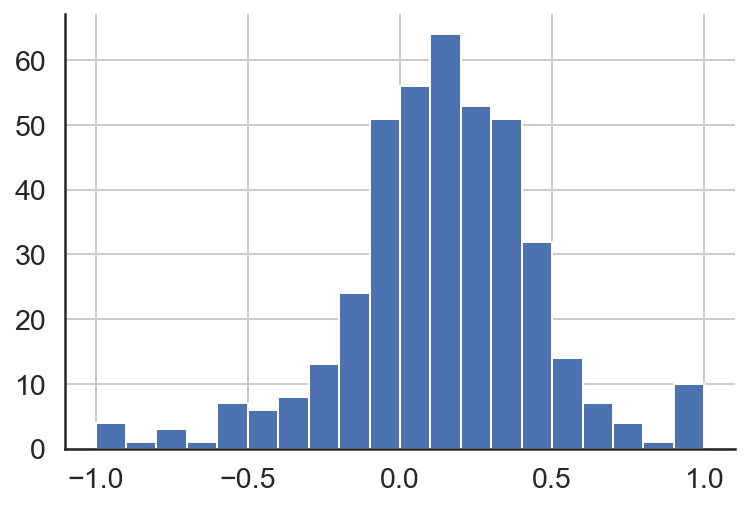

In [ ]:
print(correlations.describe())
correlations.r.hist(bins=20)

## Cognitive control
> Note that these are factor scores from the baseline analysis.

### Baseline factor scores

In [ ]:
pp_factor_scores = pd.read_pickle('/Users/hilmarzech/Projects/trr265/trr265/data/interim/factor_scores.pkl').groupby('participant').mean()

### Correlation with congruency
ToDo: Also look at separate task scores (especially SST); it could also make sense to run this longitudinally (first calculate longitudinal factor/task scores ((using baseline factor loadings)), and then run multilevel) or perhaps run lmer_within_between and get fluct and between diffs.

In [ ]:
correlations['cognitive control'] = pp_factor_scores['Factor 1']

In [ ]:
cor_fac = correlations[correlations['cognitive control'].isna()==False]

In [ ]:
display(HTML('''For %d participants, we do not have factor scores. We have both correlations and factor scores for %d participants.'''%(correlations['cognitive control'].isna().value_counts()[True], len(cor_fac))))

<AxesSubplot:xlabel='cognitive control', ylabel='r'>

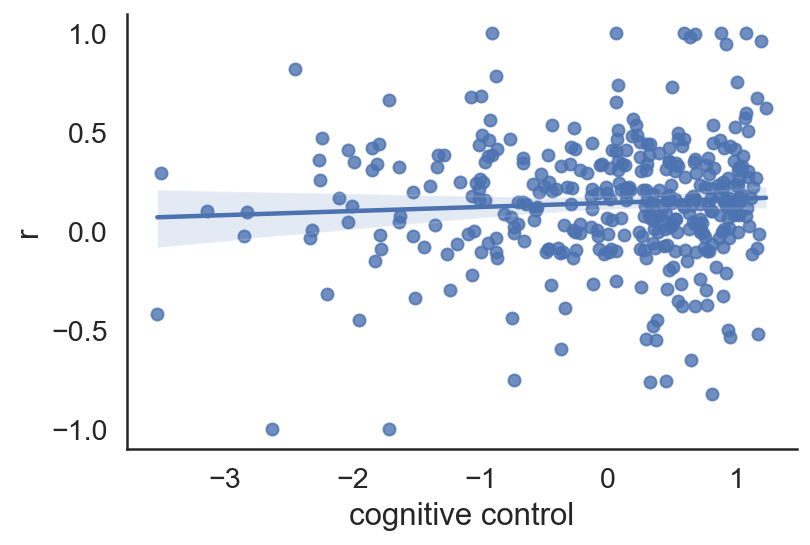

In [ ]:
sns.regplot(x = 'cognitive control', y = 'r', data = correlations)

In [ ]:
pearsonr(x = cor_fac['cognitive control'], y = cor_fac.r)

(0.06264673767432402, 0.22931016016165276)

### SST interaction with intention on drinking (longitudinal)

change in drinking ~ intention * SST + (1 + intention * SST | participant )
try to do this with lmer_within_between

### Longitudinal factor scores
(based on baseline factor loadings)

### Groups

In [ ]:
cor_fac["high congruency"] = cor_fac.r > cor_fac.r.median()
cor_fac["high cognitive control"] = cor_fac['cognitive control'] > cor_fac['cognitive control'].median()

In [ ]:
pd.crosstab(cor_fac["high congruency"],cor_fac["high cognitive control"], dropna = True)

high cognitive control,False,True
high congruency,,
False,87,98
True,98,87


> This shows that cog. con and congr. is independent. This supports our point that mobilization is important.

### Correlation with other scores

#### Perceived loss of control

In [ ]:
two_day.query('participant=="d170" and (Kontrolle==Kontrolle)')[['date','control','Kontrolle']]

,date,control,Kontrolle
two_day_index,,,
112984,2022-01-16,1.0,1.0
112992,2022-01-24,1.0,1.0
113000,2022-02-01,2.0,2.0
113010,2022-02-11,3.0,3.0
113018,2022-02-19,1.0,1.0
113080,2022-04-22,2.0,2.0
113132,2022-06-13,3.0,3.0


#### AUDIT

#### AUD

In [ ]:
#aud = aud.reset_index()

In [ ]:
aud = aud.groupby('participant').first()

In [ ]:
correlations['aud'] = aud['aud']
correlations.aud.isna().value_counts()

False    410
Name: aud, dtype: int64

<AxesSubplot:xlabel='r', ylabel='aud'>

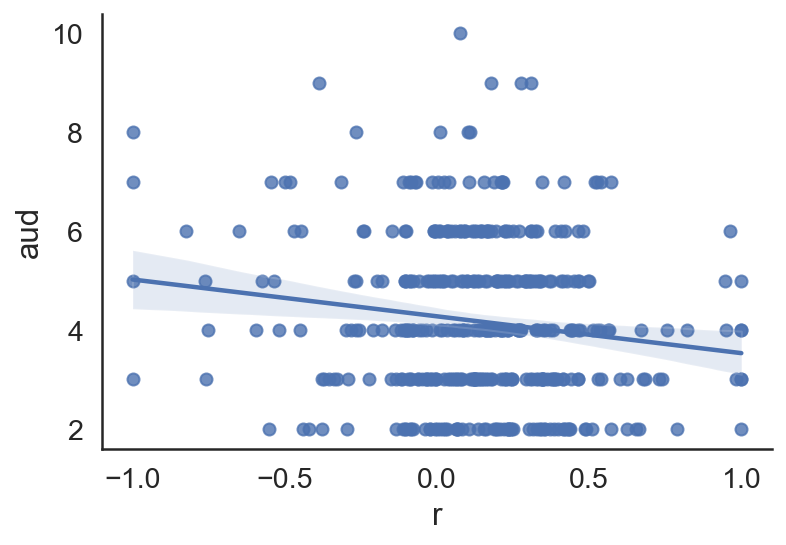

In [ ]:
sns.regplot(x = 'r', y = 'aud', data = correlations)

In [ ]:
pearsonr(x = correlations.r, y = correlations.aud)

(-0.1457512868166722, 0.0030960222809223513)

We can stick to AUD criteria and do not need to validate this against many other measures (but we could of course explore other measures; AUDIT, etc.).

## Summary
We have EMA data from 595 participants.
For 545 participants differences in drinking could be calculated.
Correlations could be calculated for 410 participants.
370 participants have both correlations and cognitive control scores (from baseline). The final group sizes after median splits are below:

In [ ]:
pd.crosstab(cor_fac["high congruency"],cor_fac["high cognitive control"], dropna = True)

high cognitive control,False,True
high congruency,,
False,87,98
True,98,87


## Mixed model calculations